## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

## Read/Transform Data

In [2]:
#read data
df = pd.read_csv('cleaned-data.csv')

In [3]:
#join and shuffle data
df = df.sample(frac=1).reset_index(drop=True) #sample shuffles the data
df.head()

,Lyric,Genres
0,a folk of cheeriness and strength content with...,Heavy Metal
1,if you aint got no money 4x if youre independe...,Pop
2,come on i wanna dance in the dark come on were...,Pop
3,the moon begins to rise upon my fallen eyes im...,Rock
4,i had a dream so big and loud i jumped so high...,Pop; Rock


In [4]:
indexNames = []
for index, row in df.iterrows():
    if len(row.Genres.split("; "))>1: #or (row.Genres != "Pop" and row.Genres!="Rap"):
        indexNames.append(index)
df = df.drop(indexNames)

In [5]:
"""indexNames = []
counters = dict()
for index, row in df.iterrows():
    if row.Genres in counters:
        if counters[row.Genres]>=15000:
            indexNames.append(index)
        else:
            counters[row.Genres] += 1
    else:
        counters[row.Genres] = 1
df = df.drop(indexNames)"""

'indexNames = []\ncounters = dict()\nfor index, row in df.iterrows():\n    if row.Genres in counters:\n        if counters[row.Genres]>=15000:\n            indexNames.append(index)\n        else:\n            counters[row.Genres] += 1\n    else:\n        counters[row.Genres] = 1\ndf = df.drop(indexNames)'

In [6]:
x = np.array(df['Lyric']) #"text"
y = np.array(df['Genres'])

In [7]:
"""
genres = []

for i in range(len(y)):
    genres.extend(y[i].split("; "))

genres = set(genres)

genre_id = dict()

i=0
for genre in genres:
    genre_id[genre] = i
    i += 1
"""

'\ngenres = []\n\nfor i in range(len(y)):\n    genres.extend(y[i].split("; "))\n\ngenres = set(genres)\n\ngenre_id = dict()\n\ni=0\nfor genre in genres:\n    genre_id[genre] = i\n    i += 1\n'

<AxesSubplot:>

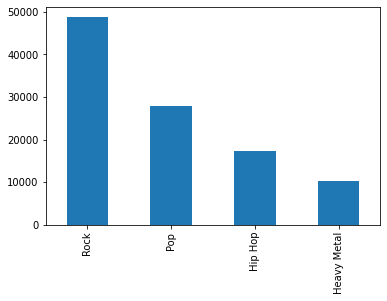

In [8]:
df['Genres'].value_counts().plot.bar()

In [9]:
# tokenizer to transform text into tokens
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=10000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token=None,
    #document_count=0, **kwargs
)

# Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(x)

#Transforms each text in x to a sequence of integers.
x = tokenizer.texts_to_sequences(x)

#Pads sequences to the same length. In this case, with maxlen of 100 integers
x = pad_sequences(x, maxlen = 250)

"""
new_y = []
for string in y:
    new_y.append([0 for _ in range(len(genres))])
    for g in string.split("; "):
        new_y[-1][genre_id[g]]=1

y = np.array(new_y)
"""

# tokenizer to transform text into tokens
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=1000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split='; ', char_level=False, oov_token=None,
    #document_count=0, **kwargs
)

# Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(y)

#Transforms each text in x to a sequence of integers.
y = tokenizer.texts_to_sequences(y)

y = np.array([elem[0]-1 for elem in y])

In [10]:
def LSTM_Model(vocab_size=10000, features=512, input_length=250, learning_rate=0.001, dropout=0):
    model=Sequential()
    # Embedding layer
    model.add(Embedding(vocab_size,features,input_length=input_length))
    # Long Short Term Memory layer
    model.add(LSTM(256, dropout=dropout))
    # Output layer
    model.add(Dense(6,activation='sigmoid'))
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
model = LSTM_Model()
res = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=34,batch_size=64)

2022-07-03 15:53:58.439861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 15:53:58.480926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 15:53:58.481154: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 15:53:58.481919: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/34


2022-07-03 15:54:01.025362: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


1299/1299 [==============================] - 176s 134ms/step - loss: 0.9290 - accuracy: 0.6054 - val_loss: 0.7646 - val_accuracy: 0.6805
Epoch 2/34
1299/1299 [==============================] - 180s 139ms/step - loss: 0.6902 - accuracy: 0.7139 - val_loss: 0.7056 - val_accuracy: 0.7084
Epoch 3/34
1299/1299 [==============================] - 182s 140ms/step - loss: 0.5946 - accuracy: 0.7569 - val_loss: 0.7122 - val_accuracy: 0.7115
Epoch 4/34
1299/1299 [==============================] - 182s 140ms/step - loss: 0.5206 - accuracy: 0.7875 - val_loss: 0.7343 - val_accuracy: 0.7082
Epoch 5/34
1299/1299 [==============================] - 181s 140ms/step - loss: 0.4501 - accuracy: 0.8179 - val_loss: 0.7869 - val_accuracy: 0.6945
Epoch 6/34
1299/1299 [==============================] - 178s 137ms/step - loss: 0.3876 - accuracy: 0.8441 - val_loss: 0.8593 - val_accuracy: 0.6980
Epoch 7/34
1299/1299 [==============================] - 178s 137ms/step - loss: 0.3250 - accuracy: 0.8718 - val_loss: 0.973